In [ ]:
!pip install --upgrade datasets fsspec

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 6.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; pla

In [ ]:
from google.colab import drive
#!pip install transformers datasets accelerate


drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
from datasets import load_dataset
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, TrainingArguments, Trainer
import torch
from datasets import load_dataset, Dataset
from google.colab import drive
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
import os
from transformers import AutoModelForCausalLM
from peft import prepare_model_for_kbit_training, LoraConfig, get_peft_model


dataset = load_dataset("isaacrehg/poetry-instructions", verification_mode="no_checks")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

(…)-00000-of-00001-f9026b3e4b9aab48.parquet:   0%|          | 0.00/80.9M [00:00<?, ?B/s]

(…)-00000-of-00001-8b9ddb74a3fd048e.parquet:   0%|          | 0.00/5.08M [00:00<?, ?B/s]

(…)-00000-of-00001-1c0e7b1de7a62c6e.parquet:   0%|          | 0.00/17.8M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1322 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/111 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/331 [00:00<?, ? examples/s]

In [ ]:
print(dataset)
print(dataset['train'][0])

DatasetDict({
    train: Dataset({
        features: ['conversation'],
        num_rows: 1764
    })
    validation: Dataset({
        features: ['conversation'],
        num_rows: 111
    })
    test: Dataset({
        features: ['conversation'],
        num_rows: 331
    })
})
{'conversation': "User: Can you write me a poem about faults and love?\nAssistant: Sure, here's a poem about faults and love:\n  They came to tell your faults to me,\nThey named them over one by one;\nI laughed aloud when they were done,\nI knew them all so well before, \nOh, they were blind, too blind to see\nYour faults had made me love you more."}


In [ ]:
# Define parsing function
def parse_example(example):
    convo = example["conversation"]

    # Split on 'Assistant:'
    if "Assistant:" in convo:
        user_part, assistant_part = convo.split("Assistant:", 1)

        # Clean User: part
        prompt = user_part.replace("User:", "").strip()

        # Clean Assistant: part
        completion = assistant_part.strip()

    else:
        # If no Assistant:, fallback
        prompt = convo
        completion = ""

    return {
        "prompt": prompt,
        "completion": completion
    }

# Apply to all splits
dataset["train"] = dataset["train"].map(parse_example)
dataset["validation"] = dataset["validation"].map(parse_example)
dataset["test"] = dataset["test"].map(parse_example)

# Remove 'conversation' column
dataset["train"] = dataset["train"].remove_columns(['conversation'])
dataset["validation"] = dataset["validation"].remove_columns(['conversation'])
dataset["test"] = dataset["test"].remove_columns(['conversation'])

# Check result
print(dataset["train"])
print(dataset["train"].column_names)
print(dataset["train"][0])



Map:   0%|          | 0/1764 [00:00<?, ? examples/s]

Map:   0%|          | 0/111 [00:00<?, ? examples/s]

Map:   0%|          | 0/331 [00:00<?, ? examples/s]

Dataset({
    features: ['prompt', 'completion'],
    num_rows: 1764
})
['prompt', 'completion']
{'prompt': 'Can you write me a poem about faults and love?', 'completion': "Sure, here's a poem about faults and love:\n  They came to tell your faults to me,\nThey named them over one by one;\nI laughed aloud when they were done,\nI knew them all so well before, \nOh, they were blind, too blind to see\nYour faults had made me love you more."}


In [ ]:
path = '/content/drive/Shareddrives/DeepLearning/UPF_Deep_Learning_2025/Project/Codi'

model = AutoModelForCausalLM.from_pretrained(os.path.join(path, "copia_funciona_gpt2"))
tokenizer = AutoTokenizer.from_pretrained(os.path.join(path, "copia_funciona_gpt2"))

In [ ]:
# Define tokenization function
def tokenize(example):
    # List comprehension: for each example in batch
    texts = [
        p + " " + c
        for p, c in zip(example["prompt"], example["completion"])
    ]

    # Tokenize the batch of texts
    encodings = tokenizer(
        texts,
        padding="max_length",
        truncation=True,
        max_length=512
    )

    return {
        "input_ids": encodings["input_ids"],
        "attention_mask": encodings["attention_mask"],
        "labels": encodings["input_ids"]  # causal LM: labels = input_ids
    }


# Apply to each split

tokenized_train = dataset["train"].map(
    tokenize,
    batched=True,
    remove_columns=["prompt", "completion"]
)

tokenized_val = dataset["validation"].map(
    tokenize,
    batched=True,
    remove_columns=["prompt", "completion"]
)

tokenized_test = dataset["test"].map(
    tokenize,
    batched=True,
    remove_columns=["prompt", "completion"]
)




Map:   0%|          | 0/1764 [00:00<?, ? examples/s]

Map:   0%|          | 0/111 [00:00<?, ? examples/s]

Map:   0%|          | 0/331 [00:00<?, ? examples/s]

In [ ]:
# Check result
print(tokenized_train)
print(tokenized_train.column_names)
print(tokenized_train[0])

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 1764
})
['input_ids', 'attention_mask', 'labels']
{'input_ids': [6090, 345, 3551, 502, 257, 21247, 546, 31025, 290, 1842, 30, 10889, 11, 994, 338, 257, 21247, 546, 31025, 290, 1842, 25, 198, 220, 1119, 1625, 284, 1560, 534, 31025, 284, 502, 11, 198, 2990, 3706, 606, 625, 530, 416, 530, 26, 198, 40, 13818, 32227, 618, 484, 547, 1760, 11, 198, 40, 2993, 606, 477, 523, 880, 878, 11, 220, 198, 5812, 11, 484, 547, 7770, 11, 1165, 7770, 284, 766, 198, 7120, 31025, 550, 925, 502, 1842, 345, 517, 13, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 5

In [ ]:
training_args = TrainingArguments(
    output_dir=os.path.join(path, "copia_funciona_gpt2_f"),
    per_device_train_batch_size=2,
    gradient_accumulation_steps=4,
    num_train_epochs=10,
    learning_rate=1e-4,
    fp16=True,
    save_strategy="epoch",
    logging_steps=10,
    report_to="none"
)

trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val
)

trainer.train()
eval_results = trainer.evaluate()
print(f"Validation results: {eval_results}")
test_results = trainer.evaluate(tokenized_test)
print(f"Test results: {test_results}")

<ipython-input-9-3a410f7f0a59>:13: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Step,Training Loss
10,3.434600
20,3.157100
30,3.431000
40,3.129100
50,3.519200
60,3.167800
70,3.196200
80,3.095200
90,3.076000
100,2.903100


Validation results: {'eval_loss': 2.1365230083465576, 'eval_runtime': 2.322, 'eval_samples_per_second': 47.803, 'eval_steps_per_second': 6.029, 'epoch': 10.0}
Test results: {'eval_loss': 2.131948471069336, 'eval_runtime': 6.6458, 'eval_samples_per_second': 49.806, 'eval_steps_per_second': 6.32, 'epoch': 10.0}


In [ ]:
model.eval()
prompt = "The sea is blue, the sky is red"

# Tokenize input
inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

# Generate text
output = model.generate(
    **inputs,
    max_new_tokens=250,
    temperature=0.7,
    top_p=0.95,
    do_sample=True,
    repetition_penalty=1.1,
    eos_token_id=tokenizer.eos_token_id
)

# Decode and print
generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
print(generated_text)


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The sea is blue, the sky is red;
And I hear the great bird of dawn calling his song.  Go and fetch him!
We have come to an end: he has departed from us._
I will not leave you alone now--let me go with thee again.--Go and fetch Him again!--Let there be light at last for my soul's end." The angel Gabriel looked upon them in wonderment as they flew away from Jerusalem toward Babylon on their way back to Bethlehem where they would receive Jesus Christ as His Saviour who came to save them from a great Satan that had put an endto all evil that had taken place in their hearts and souls and made them blind even unto themselves because He gave them knowledge about the law which was laid down by God in preparing them (Genesis xxxiii. 17-19).


In [ ]:
prompt = "Write a poem about the sea and the sky"

# Tokenize input
inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

# Generate text
output = model.generate(
    **inputs,
    max_new_tokens=250,
    temperature=0.7,
    top_p=0.95,
    do_sample=True,
    repetition_penalty=1.1,
    eos_token_id=tokenizer.eos_token_id
)

# Decode and print
generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
print(generated_text)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Write a poem about the sea and the sky in the style of SIR PHILIP SIDNEY? Sure, here's a poem about you and the skies:
  To-morrow night I shall be flying on this high mountain top;--it is my
mission to give sound pleasure into your ears. You will not hear me
stirring in your ears that these lines which are so singularly true have been
made famous by such an author as yourselves.--_A Poet_. _Hymn for God! My Lord."]


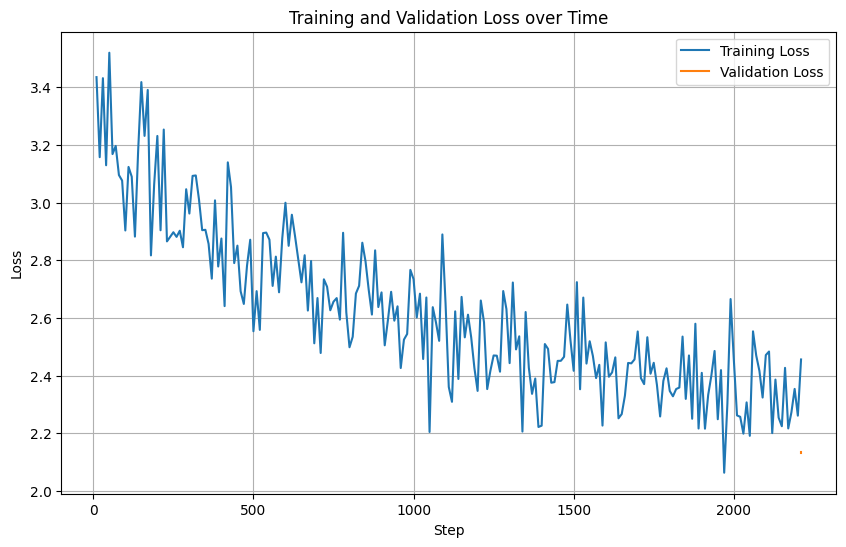

In [ ]:
import matplotlib.pyplot as plt

# Extract log history
logs = trainer.state.log_history

# Get training and eval losses
train_steps = [log["step"] for log in logs if "loss" in log]
train_loss = [log["loss"] for log in logs if "loss" in log]

eval_steps = [log["step"] for log in logs if "eval_loss" in log]
eval_loss = [log["eval_loss"] for log in logs if "eval_loss" in log]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(train_steps, train_loss, label="Training Loss")
plt.plot(eval_steps, eval_loss, label="Validation Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.title("Training and Validation Loss over Time")
plt.show()
